# TP 3: Autoencoder, Generative Adversarial Networks (GANs)

## Objective: Implement a AE & GAN with Pytorch

## Load the useful packages

In [ ]:
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import matplotlib.gridspec as gridspec
import seaborn # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library
from tqdm import tqdm #progress bar

import torch

import time
import os
import pickle

Set the device

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" #0 indicates the GPU you gonna use
print(f"Using {device} device")

## Load and preprocess the data

#### Description of the data:
There are  labeled subsets of the 10 handwritten digits and consists of 70000 **28x28** grayscale images of 10 classes, with 7000 images per class. There are **60000 training images** and **10000 test images**. Source: http://yann.lecun.com/exdb/mnist/

No need to download the labels as we will not perform classification. We use only a training set.

The data can be directly downloaded with PyTorch. Please visit the following website: https://pytorch.org/vision/stable/datasets.html.
The dataset must have the same number of channels as the original dataset used for the pretrained model.

In [ ]:
from torchvision import datasets
from torchvision import transforms

# set transformation
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

traindata = datasets.MNIST(
    root="~/data",
    train=True,
    download=True,
    transform=transform
)

testdata = datasets.MNIST(
    root="~/data",
    train=False,
    download=True,
    transform=transform
)

In [ ]:
traindata

In [ ]:
traindata.data.float().mean(axis=(0,1,2))

In [ ]:
traindata.data.float().std(axis=(0,1,2))

In [ ]:
traindata[0][0].shape

In [ ]:
plt.imshow(traindata[0][0].view(28,28))

In [ ]:
num_examples = len(traindata)
num_examples

Convert to dataloader

Batch size: 64



In [ ]:
batch_size=64
train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, num_workers=2)

In [ ]:
img_batch,_ = next(iter(train_loader))
print(img_batch.min(),img_batch.max())

## Implement the models

### Autoencoder

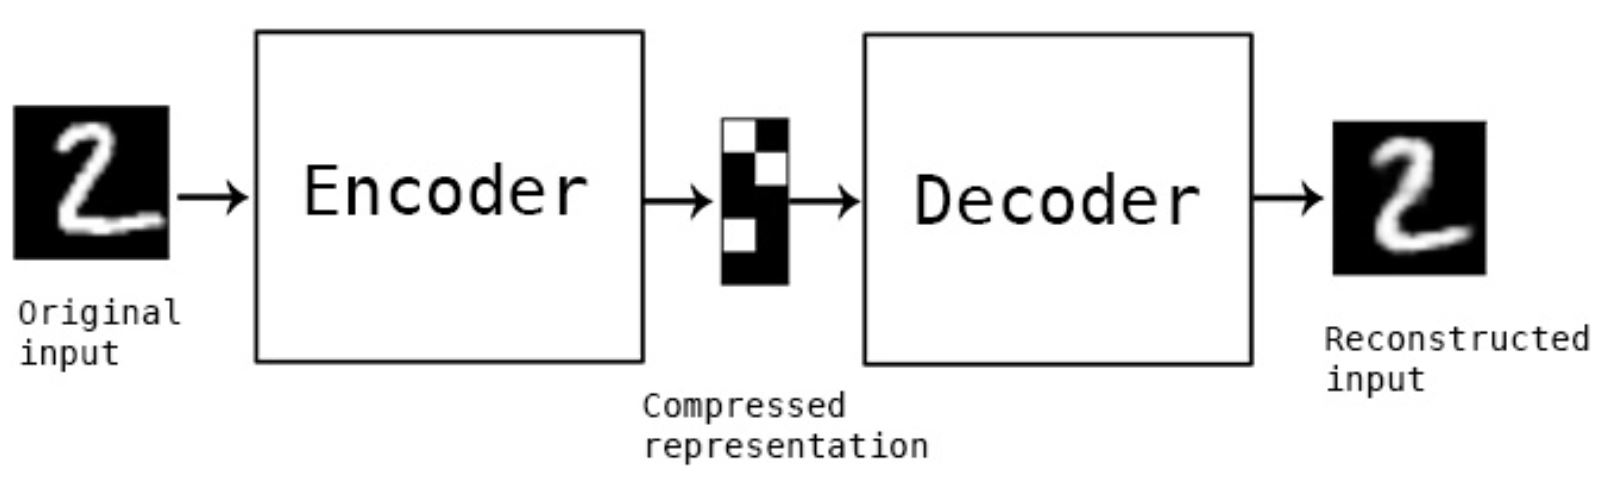

We consider a architecture of 4 layers

In [ ]:
from torch import nn
class AE(nn.Module):
    def __init__(self,input_shape,intermediate_shape,latent_shape):
      # to fill
      super().__init__()
      self.h1 = nn.Linear(
            in_features=input_shape, out_features=intermediate_shape
        )
      self.h2 = nn.Linear(
          in_features=intermediate_shape, out_features=latent_shape
      )
      self.h2tilde = nn.Linear(
          in_features=latent_shape, out_features=intermediate_shape
      )
      self.h1tilde = nn.Linear(
          in_features=intermediate_shape, out_features=input_shape
      )

    def forward(self, x):
      x = self.h1(x)
      x = torch.relu(x)
      x = self.h2(x)
      x = torch.relu(x)
      x = self.h2tilde(x)
      x = torch.relu(x)
      x = self.h1tilde(x)
      x = torch.tanh(x) # be careful with the last activation function that scales the output data
      return x

Instantiate the model

In [ ]:
ae = AE(input_shape=784,intermediate_shape=128,latent_shape=32)
ae.to(device)

Set the criterion and the optimizer

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

Launch the training

In [ ]:
from tqdm import tqdm

epochs = 3
loss_train =[]
loss_test =[]


for epoch in tqdm(range(epochs)):

  # Training
  ae.train()
  loss_train.append([])
  for batch in train_loader:
    img_batch,_ = batch
    img_batch=img_batch.view(-1, 784).to(device) #train on GPU

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    out = ae(x=img_batch)
    loss = criterion(out, img_batch)
    loss.backward()
    optimizer.step()

    # print statistics
    loss_train[epoch].append(loss.item())

  loss_train[epoch]=np.mean(loss_train[epoch])
  if epoch % 5 == 0:    # print every 5 epochs
      print('Epoch {}/{}: train loss: {}'.format(epoch,epochs,loss_train[epoch]))

  # Eval
  ae.eval()
  loss_test.append([])
  with torch.no_grad():
    for batch in test_loader:
      mg_batch,_ = batch
      img_batch=img_batch.to(device) #train on GPU

      # forward + backward + optimize
      out = ae(x=img_batch)
      loss = criterion(out, img_batch)

      # print statistics
      loss_test[epoch].append(loss.item())

    loss_test[epoch]=np.mean(loss_test[epoch])
    if epoch % 5 == 0:    # print every 5 epochs
        print('Epoch {}/{}: test loss: {}'.format(epoch,epochs,loss_test[epoch]))

Plot the results

In [ ]:
def plot_ae_outputs(net,n=10):
    plt.figure(figsize=(16,4.5))
    targets = testdata.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = testdata[t_idx[i]][0]
      net.eval()
      with torch.no_grad():
         rec_img  = net(img.view(784).to(device))
      plt.imshow(img.view(28,28), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().numpy().reshape(28,28), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [ ]:
plot_ae_outputs(net=ae,n=10)

Print the loss curve

In [ ]:
plt.plot(loss_train, label='Train')
plt.plot(loss_test, label='Test')
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
plt.legend()
plt.show()

## Other way of defining the AE

Split into an Encoder class and decoder class

In [ ]:
# New AE

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_shape, latent_shape):
      # to fill
      super().__init__()
      # TODO

    def forward(self, x):
      # TODO
      return x

class Decoder(nn.Module):
    def __init__(self, latent_shape, hidden_shape, output_shape):
      # to fill
      # TODO

    def forward(self, x):
      # TODO
      return x


class AE(nn.Module):
    def __init__(self,input_shape,intermediate_shape,latent_shape):
      # to fill
      super().__init__()
      self.encoder = Encoder(...)
      self.decoder = Decoder(...)

    def forward(self, x):
      # TODO
      # Careful to put a non linear activation function between encoder and decoder

In [ ]:
ae = AE(...)
print(ae)

### Latent space visualization: https://github.com/gr-b/autoencoder-latent-space-visualization

### GAN

#### Configuration of the two networks

Generator network:

In [ ]:
from torch import nn
class Generator(nn.Module):
  def __init__(self, dim_z, dim_output):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(dim_z, 256)
    self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
    self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
    self.fc4 = nn.Linear(self.fc3.out_features, dim_output)
  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.tanh(self.fc4(x)) # be careful with the last activation function that scales the output data
    return x

Discriminator network:

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, dim_x):
      super(Discriminator, self).__init__()
      self.fc1 = nn.Linear(dim_x, 1024)
      self.fc2 = nn.Linear(self.fc1.out_features, 512)
      self.fc3 = nn.Linear(self.fc2.out_features, 256)
      self.fc4 = nn.Linear(self.fc3.out_features, 1)

  def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = torch.relu(self.fc3(x))
      x = self.fc4(x)
      return x

#### Losses and optimizers

Dimensions of the input of each network:

In [ ]:
dim_z = 128
dim_x = traindata[0][0].size(1) * traindata[0][0].size(2)

In [ ]:
dim_x # size of the flattened image

In [ ]:
G = Generator(dim_z = dim_z, dim_output = dim_x).to(device)
D = Discriminator(dim_x = dim_x).to(device)

Dual min-max optimization problem:

$$\max_D L_D=\mathbb{E}_{x\sim P_{data}(x)}\big[\log p(y=1|x,D)\big]+\mathbb{E}_{z\sim P(z)}\big[\log (1-p(y=1|G(z),D))\big]$$

$$\min_G L_G=\mathbb{E}_{z\sim P(z)}\big[\log (1-p(y=1|G(z),D))\big]$$ $$\equiv \max_G L_G=\mathbb{E}_{z\sim P(z)}\big[\log p(y=1|G(z),D)\big]$$

Note that:
- a maximization problem can be transformed into a minimization problem.  
- each model has its own optimizer and learning rate
- alternate the training of the 2 networks

Cross entropy loss:

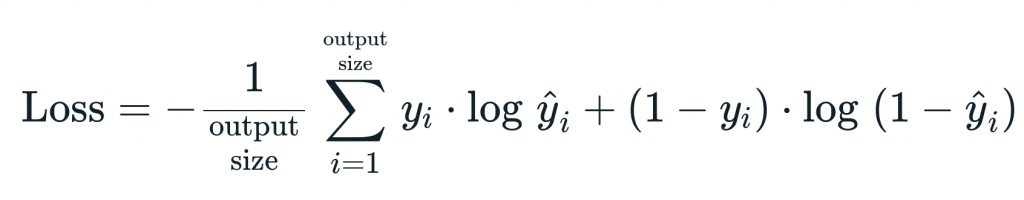

Documentation BCE loss: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

"*This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.*"

In [ ]:
# loss
criterion = nn.BCEWithLogitsLoss()

# optimizer
lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [ ]:
def discriminator_loss(real_output, fake_output,batch_size):
    real_loss = criterion(input=real_output,target=torch.ones(batch_size,1).to(device)) # target labels as ones for real data
    fake_loss = criterion(input=fake_output,target=torch.zeros(batch_size,1).to(device)) # target labels as zeros for fake data
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
def generator_loss(fake_output,batch_size):
    return criterion(input=fake_output, target=torch.ones(batch_size,1).to(device)) # target labels as ones for fake data to fool the discriminator

#### Training

The training loop has to be implemented, as follows:

In [ ]:
def train_step(images,batch_size):
    D.zero_grad()

    #### DISCRIMINATOR ####

    # train discriminator on real
    x_real = images.view(-1, dim_x).to(device)

    real_output = D(x_real)

    # train discriminator on fake
    z = torch.randn(batch_size, dim_z).to(device) # input noise vector

    fake_output = D(G(z).detach())

    # gradient backprop & optimize ONLY D's parameters
    D_loss = discriminator_loss(real_output, fake_output, batch_size)
    D_loss.backward()
    D_optimizer.step()

    #### GENERATOR ####

    G.zero_grad()

    z = torch.randn(batch_size, dim_z).to(device)
    fake_output = D(G(z))

    # gradient backprop & optimize ONLY G's parameters
    G_loss = generator_loss(fake_output, batch_size)
    G_loss.backward()
    G_optimizer.step()

    return D_loss, G_loss


Function for visualization of the data:

In [ ]:
def plot(samples,epoch):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28)*255, cmap='Greys_r')

    plt.savefig('{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
    plt.close('all')

    return

Launch it!

- Train alternatively the two models.
- Be aware about GAN problems
    - unstable training => vanishing gradients for the Generator
    - mode dropping => missing modes in the generated data
    - mode collapse => missing diversity in the generated modes

In [ ]:
epochs = 200
display_step = 10

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
from tqdm import tqdm

D_loss =[]
G_loss =[]

for epoch in tqdm(np.arange(0,epochs)):
  D.train()
  G.train()
  D_loss.append([])
  G_loss.append([])

  for batch in train_loader:
      img_batch,_ = batch
      t_batch_size = img_batch.shape[0]
      t_D_loss,t_G_loss = train_step(img_batch,t_batch_size)
      D_loss[epoch].append(t_D_loss.item())
      G_loss[epoch].append(t_G_loss.item())

  D_loss[epoch]=np.mean(D_loss[epoch])
  G_loss[epoch]=np.mean(G_loss[epoch])

  if (epoch % display_step == 0 ) or epoch == 0 or (epoch==epochs-1):
    sample_z = torch.randn(16, dim_z).to(device)
    G.eval()
    with torch.no_grad():
      g_output = G(sample_z)
    plot(samples=g_output.cpu().numpy(),epoch=epoch)
    print("loss D:{}, loss G:{}".format(D_loss[epoch],G_loss[epoch]))

#### Analysis of the results

In [ ]:
img=plt.imread("000.png")
plt.imshow(img)

After 100 epochs:

In [ ]:
img=plt.imread("100.png")
plt.imshow(img)

After 200 epochs:

In [ ]:
img=plt.imread("199.png")
plt.imshow(img)

Print the loss curve

In [ ]:
plt.semilogy(D_loss, label='Discriminator')
plt.semilogy(G_loss, label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Average BCE Loss')
plt.legend()
plt.show()

### Let's play

Useful links:
- https://drive.google.com/file/d/1-QHdUJ21SrjVLDXHJ-iOWIKASKbIKojE/view
- https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b
- https://distill.pub/2019/gan-open-problems/#convergence
- https://medium.com/beyondminds/advances-in-generative-adversarial-networks-7bad57028032
- https://github.com/soumith/ganhacks/
- https://developers.google.com/machine-learning/gan/problems


GAN LAB : https://poloclub.github.io/ganlab/
Book: https://www.manning.com/books/gans-in-action

GAN first paper: Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680).
Tutorial: https://arxiv.org/abs/1701.00160

DCGAN: Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. CoRR, abs/1511.06434.
Tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Applications: https://jonathan-hui.medium.com/gan-some-cool-applications-of-gans-4c9ecca35900, https://github.com/nashory/gans-awesome-applications

Try to adjust the models

About GAN, you can follow the tips (see medium blogs) such as:
- Change normal distribution for uniform distribution
- Change the output function of the generator for tanh activation
- Replace ReLu by LeakyReLu
- Add regularization like Dropout, BatchNorm
- Add variability in the input (gaussian noises)
- Smooth the labels / Flip the labels
- Make deeper the architecture of both generator and discriminator networks
- ...

You can also have a look at the original paper.

Go further: Change the models by integrating a convolutional network (refer to DCGAN: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)


**Currently, the state-of-the-art GAN is the WGAN-GP: Wasserstein GAN with Gradient Penalty (https://arxiv.org/pdf/1704.00028.pdf)**


In [ ]:
# Tuning of the hyper parameters of the GAN

# TODO